Mounted at /content/drive
Google Drive mounted.
Model loaded successfully from: /content/drive/MyDrive/husob/05  Transfer_learning/cifar10_model.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,401,376 (16.79 MB)

 Trainable params: 1,065,290 (4.06 MB)

 Non-trainable params: 1,205,504 (4.60 MB)

 Optimizer params: 2,130,582 (8.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Displaying 5 random test images with predictions:


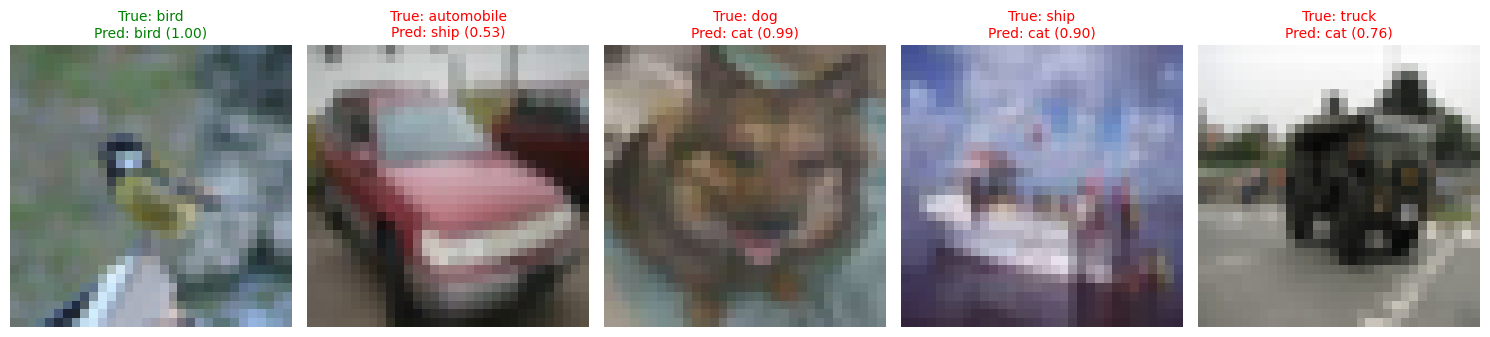


--- Model Evaluation on Full Test Set ---


In [ ]:
from keras.models import load_model
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix # Needed for confusion matrix if you add it back
from tensorflow_hub import KerasLayer
import keras
# --- Set seeds (good practice) ---
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

# --- Define class_names and constants (Crucial for interpreting predictions) ---
# These must be identical to how they were defined when the model was trained
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # Load data here for testing
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
NUM_CLASSES = len(class_names)
TARGET_SIZE_MOBILENET = (224, 224)


# --- Define and REGISTER your custom functions ---
# This is the CRITICAL change: add the decorator
@keras.saving.register_keras_serializable()
def resize_fn(image):
    return tf.image.resize(image, TARGET_SIZE_MOBILENET) # Use TARGET_SIZE_MOBILENET constant

@keras.saving.register_keras_serializable()
def preprocess_fn(image):
    return tf.keras.applications.mobilenet_v2.preprocess_input(image)


# --- Load the model ---
# Mount Google Drive if in Colab and model is on Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted.")
except Exception as e:
    print(f"Could not mount Google Drive: {e}")


model_path = '/content/drive/MyDrive/husob/05  Transfer_learning/cifar10_model.keras'

try:
    # Pass custom_objects with the REGISTERED functions
    loaded_model = load_model(
        model_path,
        custom_objects={'resize_fn': resize_fn, 'preprocess_fn': preprocess_fn},
        safe_mode=False # Still need this if using raw lambda in model definition or if you saved with it
    )
    print(f"Model loaded successfully from: {model_path}")
    loaded_model.summary()
except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
    print("Please ensure the model path is correct, functions are registered, and TensorFlow/Keras are installed.")
    # Exit or handle gracefully if model cannot be loaded
    exit() # In a script
    # raise # In a notebook if you want to stop execution


# --- Perform Predictions and Visualization ---
num_images = 5
indices = np.random.choice(len(x_test), size=num_images, replace=False)
y_test_selected = y_test[indices]

y_pred_probs = loaded_model.predict(x_test[indices])
y_pred_selected_classes = np.argmax(y_pred_probs, axis=-1)

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 4))
axes = axes.flatten()

print(f"\nDisplaying {num_images} random test images with predictions:")
for i, ax in enumerate(axes):
    original_image = x_test[indices[i]]
    true_label_idx = y_test_selected[i][0]
    predicted_label_idx = y_pred_selected_classes[i]
    confidence = y_pred_probs[i][predicted_label_idx]

    if true_label_idx == predicted_label_idx:
        title_color = 'green'
    else:
        title_color = 'red'

    ax.imshow(original_image)
    ax.set_title(
        f"True: {class_names[true_label_idx]}\n"
        f"Pred: {class_names[predicted_label_idx]} ({confidence:.2f})",
        fontsize=10,
        color=title_color
    )
    ax.axis('off')

plt.tight_layout()
plt.show()

# --- Optional: Full evaluation on test set ---
print("\n--- Model Evaluation on Full Test Set ---")
loss, accuracy = loaded_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Optional: Confusion Matrix ---
y_pred_full = loaded_model.predict(x_test)
y_pred_classes_full = np.argmax(y_pred_full, axis=-1)

cm = confusion_matrix(y_test, y_pred_classes_full)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()